# Proyecto 1 - Etapa 1

In [83]:
import pandas as pd
import nltk

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import tree
import sklearn as sklearn
from joblib import dump, load
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

In [84]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('stopwords-es')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/paulinaarrazola/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulinaarrazola/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading stopwords-es: Package 'stopwords-es' not
[nltk_data]     found in index
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/paulinaarrazola/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1. Carga de datos

In [85]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 20)
news=pd.read_csv("./fake_news.csv", sep=";")
data= news.copy()

In [86]:
data.shape

(57063, 5)

In [87]:
data.sample(5)

,ID,Label,Titulo,Descripcion,Fecha
53763,ID,1,La Constitución cumple 44 años sin reformas de...,El Gobierno opta por llevar sedes instituciona...,05/12/2022
38961,ID,0,El Supremo confirma los tres años de prisión p...,Asegura que se sirvió de sus cargos sindicales...,30/07/2020
28000,ID,1,El PSOE votará en contra de los PGE porque red...,El secretario de Política Económica y de Emple...,27/03/2018
42344,ID,1,El presidente del Grupo Zeta tilda de 'tema me...,Pablo Iglesias declaró la semana pasada que An...,02/04/2019
53031,ID,0,La coalición de izquierdas presenta una subsan...,Los servicios jurídicos consideran que esa es ...,08/05/2022


#### JUSTIFICAR LO QUE PODEMOS VER Y LA INFORMACION QUE NOS ESTAN DANDOE ESTAS VISUALIZACIONES

# 2. Entendimiento de datos

In [88]:
data.dtypes

ID             object
Label           int64
Titulo         object
Descripcion    object
Fecha          object
dtype: object

no se hace .describe porque no tiene sentido en este caso porque como todos los datos son de categoricos menos el id no tiene sentido 

In [89]:
data.isnull().sum()

ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

aclarar que no se van a quitar porque no son descripciones y se pueden identificar con id

In [90]:
#Saber cuantas de las noticias que tenemos son falsas. DESCRIBIR RESULTADOS
porcentajes = data['Label'].value_counts(normalize=True) * 100
print(porcentajes)

Label
1    58.107706
0    41.892294
Name: proportion, dtype: float64


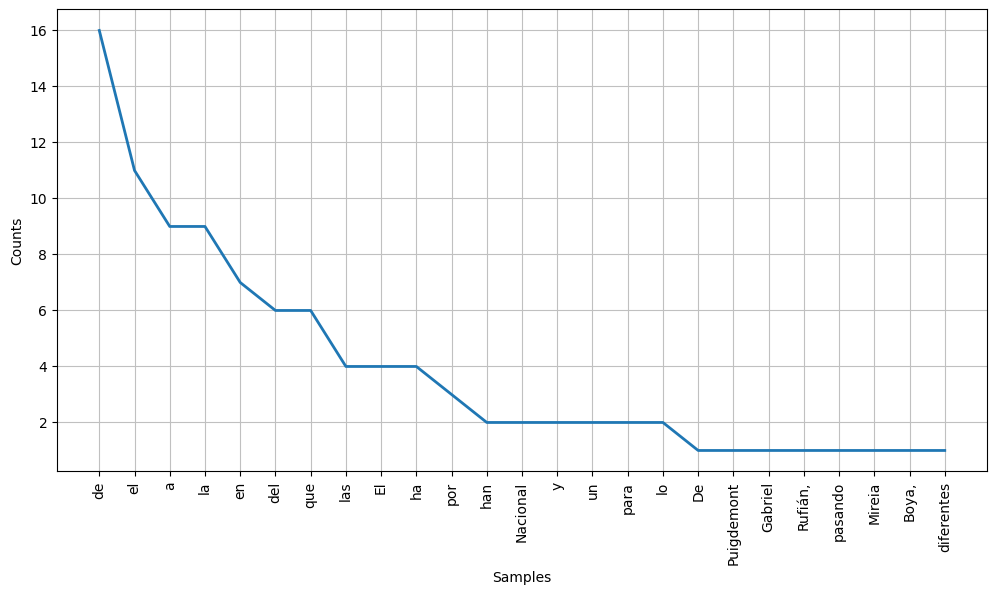

In [91]:
from nltk.probability import FreqDist
import random
import matplotlib.pyplot as plt

# Select 5 random indices within the valid range
random_indices = random.sample(range(data.shape[0]), 5)
text = ' '.join(data['Descripcion'][i] for i in random_indices)

fdist = FreqDist(text.split())

plt.figure(figsize=(12, 6))  
fdist.plot(25, cumulative=False)
plt.show()


Se cogen 5 descripciones al azar para encontrar las palabras más comunes en estos pedazos y tener un primer entendimiento de las palabras más predominantes que podemos llegar a encontrar. MENCIONAR QUE MUCHAS SON PREPOSICIONES O ARTICULOS, ADEMAS DE QUE MUCHAS TIENEN QUE VER CON POLITICA (TODAVIA NO ANALIZAR POR QUE PUEDE SER ESTO)

In [92]:
data['Descripcion'].describe()

count                                                 57063
unique                                                49638
top       La Fundación En Acción ha participado con Públ...
freq                                                      7
Name: Descripcion, dtype: object

In [93]:
data.nunique()

ID                 1
Label              2
Titulo         51604
Descripcion    49638
Fecha           2271
dtype: int64

Resgistros totales: 57063
Registros unicos: 49638
13% de las descripciones registros son duplicados
Hay títulos que comparten la misma descripcion

In [94]:
# Buscamos registros vacios
empty_texts = data[data['Descripcion'].str.strip() == '']
print(f"Descripciones vacias: {len(empty_texts)}")

Descripciones vacias: 0


# 3. Procesamiento

### 3.1 Limpieza de datos

Se eliminan los registros de las descripciones que estan repetidos porque el motor se puede confundir o puede aumentar el bias (explciar mejor por que). Se deja la primera ocurrencia. Se elimina duplicados por que no coinciden los duplicados entre columnas y hay algunas que si tiene sentido la duplicidad (la fecha)

In [95]:
data = data.drop_duplicates(subset=['Descripcion'], keep='first')
#confirmamos que se hayan eliminado los duplicados
data.shape

(49638, 5)

In [96]:
import re
import unicodedata

#Se hace una isnpeccion visual para identificar caracteres especiales que reemplazan otra letra y se incluyen en el diccionario 
# para corregirlo y no perder esas palabras cuando eliminemos los caracteres especiales

mapa_reemplazo= {
    "√°": "a",
    "√©": "e",
    "√≠": "i",
    "√≥": "o",
    "√º":"ú",
    "√±": "ñ",
}

def correct_common_replacements(text):

    for wrong, right in mapa_reemplazo.items():
        text = text.replace(wrong, right)
    return text

def remove_non_ascii(words):
    
    new_words = []
    for word in words:
        if word is not None:
          new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
    return new_words

def to_lowercase(words):

    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
  
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_integers(words):
  
    new_words = []
    for word in words:
        new_word = re.sub(r"\b\d+\b", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words, stopwords=stopwords.words('spanish')):
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def preprocessing(words):
    text = ' '.join(words)
    text = correct_common_replacements(text)
    words = text.split()
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_integers(words)
    words = remove_stopwords(words)
    return words


EXPLICAR TODOS LOS PASOS ANTERIORES (ESPECIFICAMENTE POR QUE SE HACEN MAS QUE COMO)

### 3.2 Tokenización

EXPLICAR NECESIDAD Y DECIR QUE SE LE APLICAN LAS FUNCIONES DE ARRIBA PARA REDUCIR EL RUIDO (DESARROLLAR)

In [97]:
import contractions

data['Descripcion'] = data['Descripcion'].apply(contractions.fix)

In [98]:
data['words'] = data['Descripcion'].apply(word_tokenize).apply(preprocessing)
data.head()

,ID,Label,Titulo,Descripcion,Fecha,words
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023,"[diario, britanico, publico, pasado, jueves, e..."
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,"[revelan, gobierno, negocio, liberacion, mirel..."
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022,"[valencianismo, convoca, castello, fiesta, gra..."
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,"[politica, igual, negociar, empresarios, negoc..."
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,"[entrevista, punt, avui, lider, jxcat, desdram..."


### 3.3 Normalización

EXPLICAR NECESIDAD Y PROCESO

In [99]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer('spanish')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

data['words'] = data['words'].apply(stem_and_lemmatize) #Aplica lematización y eliminación de prefijos y sufijos.
data.head()

,ID,Label,Titulo,Descripcion,Fecha,words
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023,"[diari, britan, public, pas, juev, editorial, ..."
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,"[revel, gobiern, negoci, liber, mirel, cambi, ..."
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022,"[valencian, convoc, castell, fiest, grand, con..."
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,"[polit, igual, negoci, empresari, negoci, grup..."
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,"[entrev, punt, avui, lid, jxcat, desdramatiz, ..."


### 3.4 Selección de campos

Acá si explicar pasito a pasito en palabras cortas que se hizo. Ver ejemplo en gitlab

In [100]:
data['words'] = data['words'].apply(lambda x: ' '.join(map(str, x)))
data

,ID,Label,Titulo,Descripcion,Fecha,words
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023,diari britan public pas juev editorial proxim ...
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,revel gobiern negoci liber mirel cambi otorg p...
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022,valencian convoc castell fiest grand conmemor ...
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,polit igual negoci empresari negoci grup parla...
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,entrev punt avui lid jxcat desdramatiz posibl ...
...,...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,08/06/2021,gobiern regional indic atencion dia inclu aten...
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,08/09/2020,si higien democrat llev exigent ten pas person...
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,12/07/2018,coordin federal iu asegur monarqui putrefact c...
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,13/02/2022,santiag abascal vox derech deb form gobiern ca...


In [101]:
X_data, y_data = data['words'],data['Label']
y_data = (y_data == 'spam').astype(int)
y_data

0        0
1        0
2        0
3        0
4        0
        ..
57058    0
57059    0
57060    0
57061    0
57062    0
Name: Label, Length: 49638, dtype: int64

In [102]:
X_data, y_data = data['words'],data['Label']
y_data = (y_data == 5).astype(int)
y_data

0        0
1        0
2        0
3        0
4        0
        ..
57058    0
57059    0
57060    0
57061    0
57062    0
Name: Label, Length: 49638, dtype: int64

In [103]:
tf_idf = TfidfVectorizer()
X_tf_idf = tf_idf.fit_transform(X_data)
print(X_tf_idf.shape)

(49638, 58081)


# 4. Modelos

### 4.1 Random Forest (Paulina Arrázola)